# Stationrank

In [1]:
import os
import time
import json
import pygraphviz

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import datetime as dt
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [3]:
from networkx.drawing.nx_agraph import write_dot
from networkx.readwrite import json_graph
from shapely.geometry import Point, LineString
from shapely_geojson import dump, dumps, Feature, FeatureCollection
from tqdm.notebook import trange, tqdm
from scipy.linalg import norm
from scipy.linalg import eig
from matplotlib import cm
from ipywidgets import interact, interact_manual
from datetime import datetime, timedelta
from numpy import nan

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

[See the medium article 'SBB trains delay'](https://medium.com/@christopher.hogendijk/sbb-trains-delay-4b1e23f3bd15)

In [5]:
# Set month
month = 'September'

# Set index
imonth = '09'

In [6]:
# Clean data contains every "stop" for a month for all swiss railways
data = pd.read_pickle('data/istdaten/{}/data_clean_2019{}.pkl'.format(month, imonth))

In [7]:
data.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ABK,PRODUKT_ID,LINIEN_ID,LINIEN_TEXT,VERKEHRSMITTEL_TEXT,ZUSATZFAHRT_TF,FAELLT_AUS_TF,BPUIC,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF
218,01.09.2019,80:L7____:87875:000,SBB,Zug,87875,S5,S,False,False,8500090.0,Basel Bad Bf,01.09.2019 01:14,NaN,UNBEKANNT,NaN,NaN,PROGNOSE,False
350,01.09.2019,85:11:100:001,SBB,Zug,100,ICE,ICE,False,False,8500010.0,Basel SBB,NaN,NaN,PROGNOSE,01.09.2019 19:13,01.09.2019 19:13:55,REAL,False
351,01.09.2019,85:11:100:001,SBB,Zug,100,ICE,ICE,False,False,8500090.0,Basel Bad Bf,01.09.2019 19:19,01.09.2019 19:19:12,PROGNOSE,01.09.2019 19:23,01.09.2019 19:23:24,PROGNOSE,False
352,01.09.2019,85:11:1007:001,SBB,Zug,1007,IC4,IC,False,False,8503424.0,Schaffhausen,NaN,NaN,PROGNOSE,01.09.2019 05:47,01.09.2019 05:47:39,REAL,False
353,01.09.2019,85:11:1007:001,SBB,Zug,1007,IC4,IC,False,False,8503000.0,Zürich HB,01.09.2019 06:23,01.09.2019 06:22:52,REAL,NaN,NaN,PROGNOSE,False


In [8]:
# Collect features
features = []
# One feature per day
for day in data['BETRIEBSTAG'].unique():
    feature = data[(data['BETRIEBSTAG'] == day) & (data['BETREIBER_ABK'] == 'BLS-bls')]
    # Reset index
    feature = feature.reset_index()
    feature = feature.drop(columns=['index'])
    features.append(feature)

## Load stations dataset (didok)

In [9]:
# Full didok data
didok = pd.read_csv('data/istdaten/{}/dienststellenfull.csv'.format(month), header=6, sep=";")

In [10]:
# Coordinates
didok = didok[['BPUIC', 'BEZEICHNUNG_OFFIZIELL', 'ABKUERZUNG', 'E_WGS84', 'N_WGS84']].drop_duplicates()
didok = didok[np.isfinite(didok['E_WGS84'])]
didok = didok.reset_index()
didok = didok.drop(columns=['index'])
didok.head(5)

,BPUIC,BEZEICHNUNG_OFFIZIELL,ABKUERZUNG,E_WGS84,N_WGS84
0,8504048,"Villariaz, Moulin Rouge",NaN,-14.801849,35.100356
1,8504049,"Villarepos, F. de Plan",NaN,-14.764508,35.330601
2,8519024,Basel SBB RB West,BRBW,-8.092301,55.603118
3,8519025,Basel SBB RB Ost,BRBO,-8.073794,55.600495
4,8557043,"Ennetbaden, Rütenen-Felmen",NaN,0.379039,47.265918


### Locations in project as BPUIC

In [11]:
# These are the specific stations of the project
locations = data.copy(deep=True)
locations = locations[locations['BETREIBER_ABK'] == 'BLS-bls']
locations = locations[['HALTESTELLEN_NAME', 'BPUIC']].drop_duplicates()
locations.BPUIC = locations.BPUIC.astype(int)
locations = locations.reset_index()
locations = locations.drop(columns=['index'])
locations

,HALTESTELLEN_NAME,BPUIC
0,Thun,8507100
1,Uttigen,8507009
2,Kiesen,8507008
3,Wichtrach,8507007
4,Münsingen,8507006
...,...,...
188,Burgholz,8507287
189,Eifeld,8507288
190,Lattigen bei Spiez,8507299
191,Grubenwald,8507281


### Georeferenced locations by BPUIC

In [12]:
geopos = []
abbreviation = []
for i, location in enumerate(locations.values):
    abb = didok.loc[didok['BPUIC']==location[1]].values[0][2]
    lon = didok.loc[didok['BPUIC']==location[1]].values[0][3]
    lat = didok.loc[didok['BPUIC']==location[1]].values[0][4]
    loc = [lon, lat]
    geopos.append(loc)
    abbreviation.append(abb)

In [13]:
locations['abbreviation'] = abbreviation
locations['geopos'] = geopos
locations.head(5)

,HALTESTELLEN_NAME,BPUIC,abbreviation,geopos
0,Thun,8507100,TH,"[7.62959412, 46.75485381]"
1,Uttigen,8507009,UTI,"[7.5826199999999995, 46.79430001]"
2,Kiesen,8507008,KI,"[7.57549001, 46.818940000000005]"
3,Wichtrach,8507007,WCH,"[7.56884998, 46.841609399999996]"
4,Münsingen,8507006,MS,"[7.55942947, 46.87334615]"


## Preprocessing

In [14]:
def discretize(x):
    if pd.isna(x):
        return None
    else:
        x = pd.to_datetime(x)
        return int((x.hour) * 60 + x.minute)

In [15]:
def span(x):
    if pd.isna(x['arrival']) ^ pd.isna(x['departure']):
        return 1
    elif pd.isna(x['arrival']) and pd.isna(x['departure']):
        return None
    else:
        diff = x['departure'] - x['arrival']
        if diff >= 0:
            return diff + 1
        else:
            return None

In [16]:
def timeline(lst, df):
    if pd.isna(df.loc[df.index[0]].arrival):
        start = int(df.loc[df.index[0]].departure)
    else:
        start = int(df.loc[df.index[0]].arrival)
    primer = {int(i): None for i in range(0, start)}
    main = {int(j + start): [lst[j]] for j in range(0, len(lst))}
    sequel = {int(k): None for k in range(start + len(lst), 60 * 24)}
    main.update(sequel)
    primer.update(main)
    return primer

In [17]:
# Collect diaries
diaries = []

for feature in tqdm(features):

    # Diary of routes
    diary = []
    for route in tqdm(
            feature.FAHRT_BEZEICHNER.unique(),
            desc=feature['BETRIEBSTAG'].unique()[0]):

        df = feature.loc[(feature.FAHRT_BEZEICHNER == route)]

        if len(df['HALTESTELLEN_NAME']) > 1:

            df['arrival'] = df['ANKUNFTSZEIT'].apply(discretize)
            df['departure'] = df['ABFAHRTSZEIT'].apply(discretize)

            # Sort routes by scheduled departure
            df = df.sort_values(
                by='ABFAHRTSZEIT', ascending=True, na_position='last')

            df['dwell'] = df[['arrival', 'departure']].apply(span, axis=1)
            df['running'] = df['arrival'].shift(-1) - df['departure'] - 1

            # Check for timetable errors
            if any(df['running'].values.ravel() < 0):
                continue
            if any(df['dwell'].values.ravel() < 0):
                continue

            df['next'] = df['HALTESTELLEN_NAME'].shift(-1)

            sentence = []
            for i, j, k, l in df[[
                    'HALTESTELLEN_NAME', 'next', 'dwell', 'running'
            ]].values:
                if pd.isna(j) or pd.isna(l):
                    sentence.append([i])
                elif pd.isna(k):
                    sentence.append([i])
                    break
                else:
                    sentence.append([i] * int(k))
                    sentence.append([i + '=>' + j] * int(l))

            flattened = [item for sublist in sentence for item in sublist]
            dic = timeline(flattened, df)
            if len(dic) > 1440:
                print(len(dic))
                break
            diary.append(dic)

    # Fill in the diaries
    diaries.append(pd.DataFrame(diary))

In [18]:
df

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ABK,PRODUKT_ID,LINIEN_ID,LINIEN_TEXT,VERKEHRSMITTEL_TEXT,ZUSATZFAHRT_TF,FAELLT_AUS_TF,BPUIC,...,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF,arrival,departure,dwell,running,next
15539,30.09.2019,85:33:86533:002,BLS-bls,Zug,86533,S44,S,True,False,8508080.0,...,PROGNOSE,30.09.2019 10:15,30.09.2019 10:19:17,REAL,False,NaN,615.0,1.0,4.0,Hasle-Rüegsau
15540,30.09.2019,85:33:86533:002,BLS-bls,Zug,86533,S44,S,True,False,8508265.0,...,REAL,30.09.2019 10:23,30.09.2019 10:23:29,REAL,False,620.0,623.0,4.0,1.0,Lützelflüh-Goldbach
15541,30.09.2019,85:33:86533:002,BLS-bls,Zug,86533,S44,S,True,False,8508266.0,...,REAL,30.09.2019 10:25,30.09.2019 10:26:15,REAL,False,625.0,625.0,1.0,3.0,Ramsei
15542,30.09.2019,85:33:86533:002,BLS-bls,Zug,86533,S44,S,True,False,8508267.0,...,REAL,30.09.2019 10:32,30.09.2019 10:32:23,REAL,False,629.0,632.0,4.0,2.0,Grünenmatt
15543,30.09.2019,85:33:86533:002,BLS-bls,Zug,86533,S44,S,True,False,8508271.0,...,REAL,30.09.2019 10:35,30.09.2019 10:35:54,REAL,False,635.0,635.0,1.0,3.0,Sumiswald-Grünen
15544,30.09.2019,85:33:86533:002,BLS-bls,Zug,86533,S44,S,True,False,8508272.0,...,REAL,NaN,NaN,PROGNOSE,False,639.0,NaN,1.0,NaN,NaN


In [19]:
print(flattened)

['Oberburg', 'Oberburg=>Hasle-Rüegsau', 'Oberburg=>Hasle-Rüegsau', 'Oberburg=>Hasle-Rüegsau', 'Oberburg=>Hasle-Rüegsau', 'Hasle-Rüegsau', 'Hasle-Rüegsau', 'Hasle-Rüegsau', 'Hasle-Rüegsau', 'Hasle-Rüegsau=>Lützelflüh-Goldbach', 'Lützelflüh-Goldbach', 'Lützelflüh-Goldbach=>Ramsei', 'Lützelflüh-Goldbach=>Ramsei', 'Lützelflüh-Goldbach=>Ramsei', 'Ramsei', 'Ramsei', 'Ramsei', 'Ramsei', 'Ramsei=>Grünenmatt', 'Ramsei=>Grünenmatt', 'Grünenmatt', 'Grünenmatt=>Sumiswald-Grünen', 'Grünenmatt=>Sumiswald-Grünen', 'Grünenmatt=>Sumiswald-Grünen', 'Sumiswald-Grünen']


## Save the diaries for later use

In [20]:
# Export all diaries
for i, diary in enumerate(diaries):
    path = 'data/istdaten/{}/diaries/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    diary.to_pickle(path)

## Load preprocessed data

In [21]:
Diaries = []
directory = 'data/istdaten/{}/diaries/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    d = pd.read_pickle(path)
    Diaries.append(d)

## Model construction

In [22]:
# Collect starting vectors
vectors = []
# Collect transition matrices
matrices = []
# Collect states
states = []

In [23]:
for diary in tqdm(Diaries):

    # Dictionary of stations
    dic = {'station': np.unique([x for x in diary.values.ravel() if x != None])}
    stations = pd.DataFrame(dic)
    states.append(stations)

    # Size of the matrix
    n = stations.shape[0]
    # Initialize a n*1 initial start vector
    t = (n)
    Distribution = pd.DataFrame(np.zeros(t))
    Initial = pd.DataFrame(np.zeros(t))
    Frequency = pd.DataFrame(np.zeros(t))
    # Initialize a n*n transition matrix
    s = (n, n)
    matrix = pd.DataFrame(np.zeros(s))

    for row in tqdm(diary.values):
        route = [x for x in row if x != None]
        stops = [item for sublist in route for item in sublist]
        
        # Initial vector
        pos_i = stations.loc[stations['station'] == stops[0]].index[0]
        Initial.iloc[pos_i] += 1
            
        # Transition matrix
        for i in range(len(stops) - 1):
            pos1 = stations.loc[stations['station'] == stops[i]].index[0]
            pos2 = stations.loc[stations['station'] == stops[i + 1]].index[0]  
            matrix.iloc[pos1, pos2] += 1
            
    # Fill in the vectors
    s = matrix.sum()
    Distribution['Station'] = dic['station']
    Distribution['Init'] = Initial.div(Initial.sum(axis=0), axis=1)
    Distribution['Freq'] = s/sum(s)
    Distribution = Distribution.drop(columns=[0])
    vectors.append(Distribution)

    # Fill in the matrices
    tran_matrix = matrix
    tran_matrix.columns = dic['station']
    tran_matrix['Index'] = dic['station']
    tran_matrix = tran_matrix.set_index('Index')
    matrices.append(tran_matrix)

## Save the model for later use

In [24]:
# Export all vectors
for i, vector in enumerate(vectors):
    path = 'data/istdaten/{}/vectors/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    vector.to_pickle(path)

In [25]:
# Export all matrices
for i, matrix in enumerate(matrices):
    path = 'data/istdaten/{}/matrices/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    matrix.to_pickle(path)

## Loading the model

In [143]:
# Set month
month = 'September'

# Set index
imonth = '09'

In [144]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [145]:
strings = []
for i in range(1, len(Vs)+1):
    string = '{:>02}.{}.2019'.format(i, imonth)
    strings.append(string)

In [146]:
# Load transition matrices
TMs = []
directory = 'data/istdaten/{}/matrices/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory,file)
    TM = pd.read_pickle(path)
    TMs.append(TM)

In [147]:
# Now convert to probabilities
singularities = []
for i, TM in tqdm(enumerate(TMs)):
    eps = .001
    count = 0
    for row in tqdm(TM.values):
        singularities.append([])
        s = sum(row)
        k = 0
        if sum(f > 0 for k, f in enumerate(row)) == 1 and count==k:
            print('Absorbing state at', Vs[i].iloc[count][1], i, '\n')
            row[:] = eps
            row[count] = 1.0
            row[:] = [f/sum(row) for f in row]
        if s == 0:
            singularity = Vs[i].iloc[count][1]
            singularities[i].append(singularity)
            print('Singularity at', singularity, i, '\n')
            row[:] = eps
            row[count] = 1.0
            _s = sum(row)
            row[:] = [f/_s for f in row]
        else:
            row[:] = [f/s for f in row]
        TM.values[count]=row
        count+=1

In [31]:
# Overview of singularities in the system by day of occurance
singular = pd.DataFrame(singularities).dropna(how ='all')
singular

""


In [32]:
# Matrix size
sizes = []
for TM in TMs:
    s = TM.values.ravel()
    size = round(sum(s)).astype(int)
    sizes.append(size)

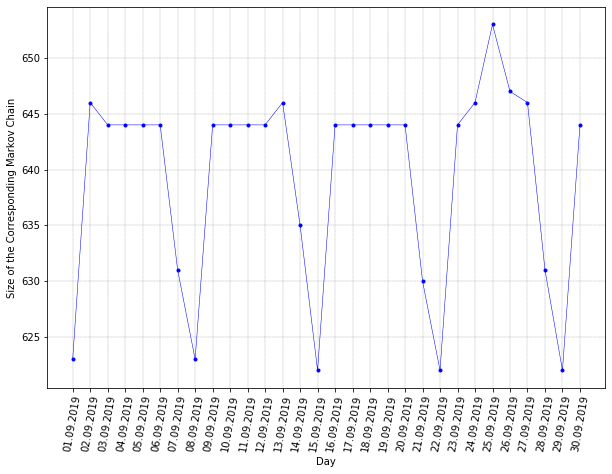

In [33]:
# Plot size
fig = plt.figure(figsize=(10, 7));
plt.plot(sizes, '.-b', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Size of the Corresponding Markov Chain')
plt.xlabel('Day')
xticks=[s for s in strings]
plt.xticks(range(len(sizes)), xticks, rotation=80, horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

## Analysis

In [34]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

### Using Power Iteration to calculate the steady state probabilities, Pi

In [35]:
Pi = []
Mixing_times = []

for TM in TMs:
    t, mixing_ = simulate_markov(TM)
    Pi.append(t)
    Mixing_times.append(mixing_)

Iterating 1622 times in 3.073040008544922
Iterating 1942 times in 3.6229472160339355
Iterating 1838 times in 3.340345621109009
Iterating 1989 times in 3.5212831497192383
Iterating 1626 times in 2.9022884368896484
Iterating 1492 times in 2.5900425910949707
Iterating 1427 times in 2.615975856781006
Iterating 1772 times in 3.195892810821533
Iterating 1520 times in 2.827970266342163
Iterating 1460 times in 2.672081470489502
Iterating 1428 times in 2.7362565994262695
Iterating 1477 times in 2.7018609046936035
Iterating 1571 times in 2.905006170272827
Iterating 1990 times in 3.819143772125244
Iterating 2135 times in 3.9765326976776123
Iterating 1526 times in 2.903477668762207
Iterating 1722 times in 3.282456636428833
Iterating 1512 times in 2.9328532218933105
Iterating 1501 times in 2.852644681930542
Iterating 1700 times in 3.2428784370422363
Iterating 1479 times in 2.696018934249878
Iterating 1993 times in 3.574249744415283
Iterating 2321 times in 4.349634170532227
Iterating 2724 times in 5

In [36]:
start = 0

### Average mixing time of Markov chains

In [37]:
# We run the power iteration for several times to see if there are some variations in the mixing time
n = 5
Mixing_times_n_times = np.zeros((n, len(TMs)))
for i in trange(n):
    for j in range(len(TMs)):
        _, mixing_ = simulate_markov(TMs[j], verbose='off')
        Mixing_times_n_times[i, j] = mixing_

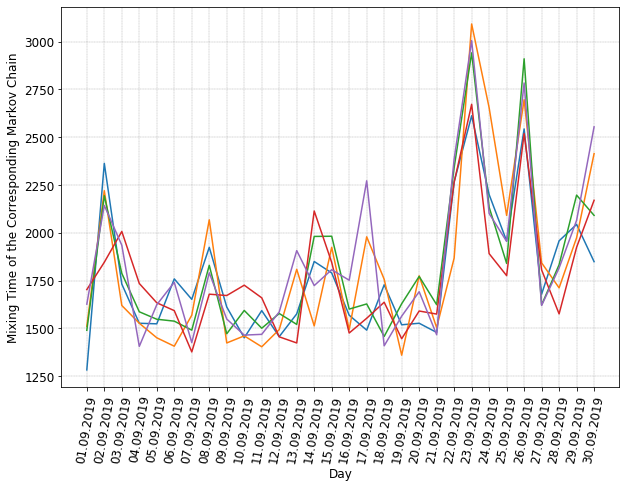

In [38]:
fig = plt.figure(figsize=(10, 7))
for mix in Mixing_times_n_times:
    plt.plot(mix[slice(start, None)])
font = {'size': 12}
plt.rc('font', **font)
plt.xlabel('Day')
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
xticks = [s for s in strings[slice(start, None)]]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks,
    rotation=80,
    horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

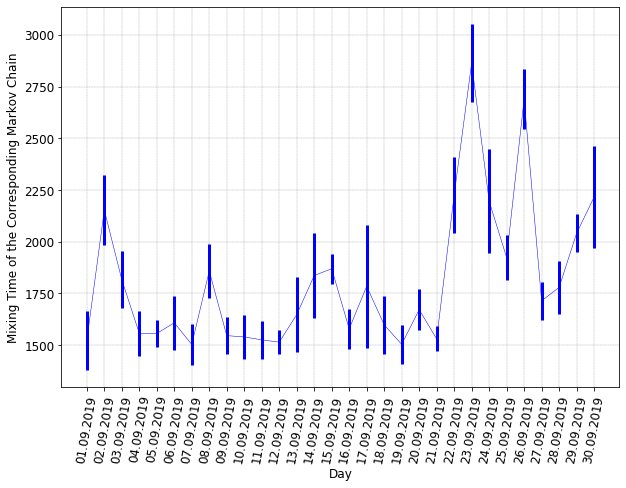

In [39]:
fig = plt.figure(figsize=(10, 7))
yerr = Mixing_times_n_times.std(axis=0)
plt.errorbar(
    range(len(TMs[slice(start, None)])),
    Mixing_times_n_times.mean(axis=0)[slice(start, None)],
    yerr=yerr[slice(start, None)],
    fmt='-',
    color='b',
    ecolor='b',
    linewidth=.5,
    elinewidth=3)
font = {'size': 12}
plt.rc('font', **font)

plt.xlabel('Day')
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
xticks = [s for s in strings[slice(start, None)]]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks,
    rotation=80,
    horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

In [40]:
def Kemeny_constant(MC):
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [41]:
Kemenys = []
pi_list = []

for TM in TMs:
    A = TM.values
    K, pi = Kemeny_constant(A)
    print(K, np.sum(pi))
    Kemenys.append(K)
    pi_list.append(pi)

7406.884601924572 1.0
7561.340913088452 0.9999999999999998
8251.69564446468 1.0
7817.688957576159 1.0
7864.651025318725 1.0000000000000002
7910.077591283877 0.9999999999999999
7496.958888720337 1.0
7382.917279716037 1.0
7786.98208817857 1.0
7840.011286900508 1.0
7805.938359826743 1.0
7795.123153548506 1.0
7789.583996501178 0.9999999999999998
7489.813514351453 1.0000000000000002
7384.0107852751435 1.0
7782.859369399868 1.0
7847.199584056274 1.0000000000000002
7769.938873109666 1.0
7887.6969525065615 1.0
7807.765072388621 1.0
7358.411980156996 1.0
7393.335422152937 1.0
7985.569142178753 1.0
7766.874884750226 1.0
7919.76026083159 0.9999999999999999
7991.966783892714 0.9999999999999999
7549.094736204129 0.9999999999999999
7367.7982106824575 1.0
7303.644107535814 1.0
7812.779693275836 1.0


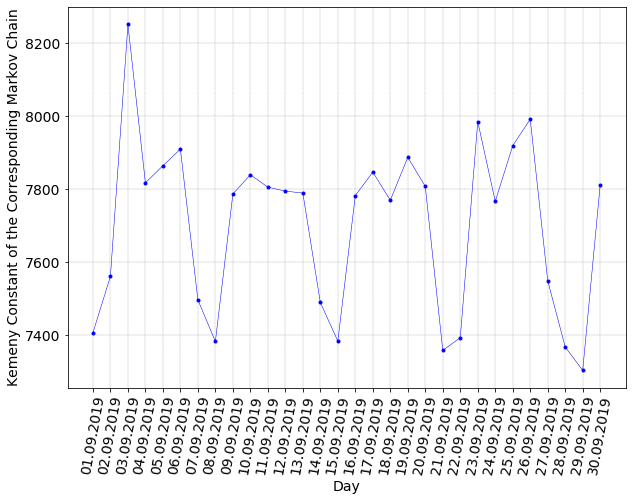

In [839]:
fig = plt.figure(figsize=(10, 7))
plt.plot(Kemenys[slice(start, None)], '.-b', linewidth=.51)

font = {'size': 12}
plt.rc('font', **font)

plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain')
xticks = [s for s in strings]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks[slice(start, None)],
    rotation=80,
    horizontalalignment='center')

plt.show()
plt.close()

In [840]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector
    Steady_dist['Pi'] = pi_list[i]
    Steady_dist['Freq'] = vector.Freq.values    
    Steady_dist['Init'] = vector.Init.values
    Steady_dist['Date'] = str(datetime(year=2019, month=9, day=int(i + 1)))
    Steady_dist['Flag'] = ~Steady_dist['Station'].str.contains('=>')
    Steady_dist = Steady_dist[['Station', 'Pi', 'Freq', 'Init', 'Date', 'Flag']]
    Steady_dist = Steady_dist[Steady_dist['Flag']]
    steady_states.append(Steady_dist)

## Results

In [841]:
# Compute pagerank
stationranks = []

for steady in steady_states:
    stationrank = steady.sort_values(['Pi'], ascending=False)
    stationrank = stationrank.reset_index()
    stationrank = stationrank.drop(columns=['index'])
    stationranks.append(stationrank)

In [842]:
# Google it!
@interact
def rank(day=(start, len(steady_states) - 1)):
    return stationranks[day]

interactive(children=(IntSlider(value=14, description='day', max=29), Output()), _dom_classes=('widget-interac…

In [843]:
# Google it!
@interact
def scatter(day=(start, len(steady_states) - 1)):
    cmap = cm.get_cmap('Spectral_r')
    fig, ax = plt.subplots(figsize=(5.5,5))
    stationranks[day].plot.scatter(x='Freq', y='Pi', s=5, c='Init', cmap=cmap, ax=ax) 

interactive(children=(IntSlider(value=14, description='day', max=29), Output()), _dom_classes=('widget-interac…

In [844]:
selected_states = []
for state in steady_states:
    state = state[state['Flag']]
    state.set_index('Station', inplace=True)
    selected_states.append(state)

In [608]:
# Merge stations over whole month
merge = pd.concat(selected_states, axis=1, join='inner')
merge

,Pi,Freq,Init,Date,Flag,Pi,Freq,Init,Date,Flag,...,Pi,Freq,Init,Date,Flag,Pi,Freq,Init,Date,Flag
Station,,,,,,,,,,,,,,,,,,,,,
Aarberg,0.000642,0.000749,0.000000,2019-09-01 00:00:00,True,0.000692,0.000677,0.000000,2019-09-02 00:00:00,True,...,0.000678,0.000709,0.000000,2019-09-29 00:00:00,True,0.000612,0.000668,0.000000,2019-09-30 00:00:00,True
Aefligen,0.001431,0.001440,0.000000,2019-09-01 00:00:00,True,0.001136,0.001373,0.000000,2019-09-02 00:00:00,True,...,0.001476,0.001362,0.000000,2019-09-29 00:00:00,True,0.001093,0.001354,0.000000,2019-09-30 00:00:00,True
Ausserberg,0.000927,0.000730,0.000000,2019-09-01 00:00:00,True,0.000755,0.000660,0.000000,2019-09-02 00:00:00,True,...,0.000974,0.000709,0.000000,2019-09-29 00:00:00,True,0.001375,0.000650,0.000000,2019-09-30 00:00:00,True
Avenches,0.000000,0.000020,0.000000,2019-09-01 00:00:00,True,0.000138,0.000196,0.001410,2019-09-02 00:00:00,True,...,0.000000,0.000019,0.000000,2019-09-29 00:00:00,True,0.000149,0.000193,0.001381,2019-09-30 00:00:00,True
Bargen,0.000661,0.000749,0.000000,2019-09-01 00:00:00,True,0.000697,0.000677,0.000000,2019-09-02 00:00:00,True,...,0.000691,0.000709,0.000000,2019-09-29 00:00:00,True,0.000621,0.000668,0.000000,2019-09-30 00:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zihlbrücke,0.000723,0.000769,0.000000,2019-09-01 00:00:00,True,0.000683,0.000713,0.000000,2019-09-02 00:00:00,True,...,0.000790,0.000746,0.000000,2019-09-29 00:00:00,True,0.000677,0.000721,0.000000,2019-09-30 00:00:00,True
Zollbrück,0.001026,0.001085,0.000000,2019-09-01 00:00:00,True,0.000898,0.000998,0.000000,2019-09-02 00:00:00,True,...,0.000926,0.001007,0.000000,2019-09-29 00:00:00,True,0.000918,0.000984,0.000000,2019-09-30 00:00:00,True
Zollikofen,0.002691,0.002820,0.000000,2019-09-01 00:00:00,True,0.005130,0.004831,0.000000,2019-09-02 00:00:00,True,...,0.002662,0.002686,0.000000,2019-09-29 00:00:00,True,0.004490,0.004746,0.000000,2019-09-30 00:00:00,True


In [609]:
indices = merge.index.values

## Share in Trains per Day (red) compared to structural power (blue) over time

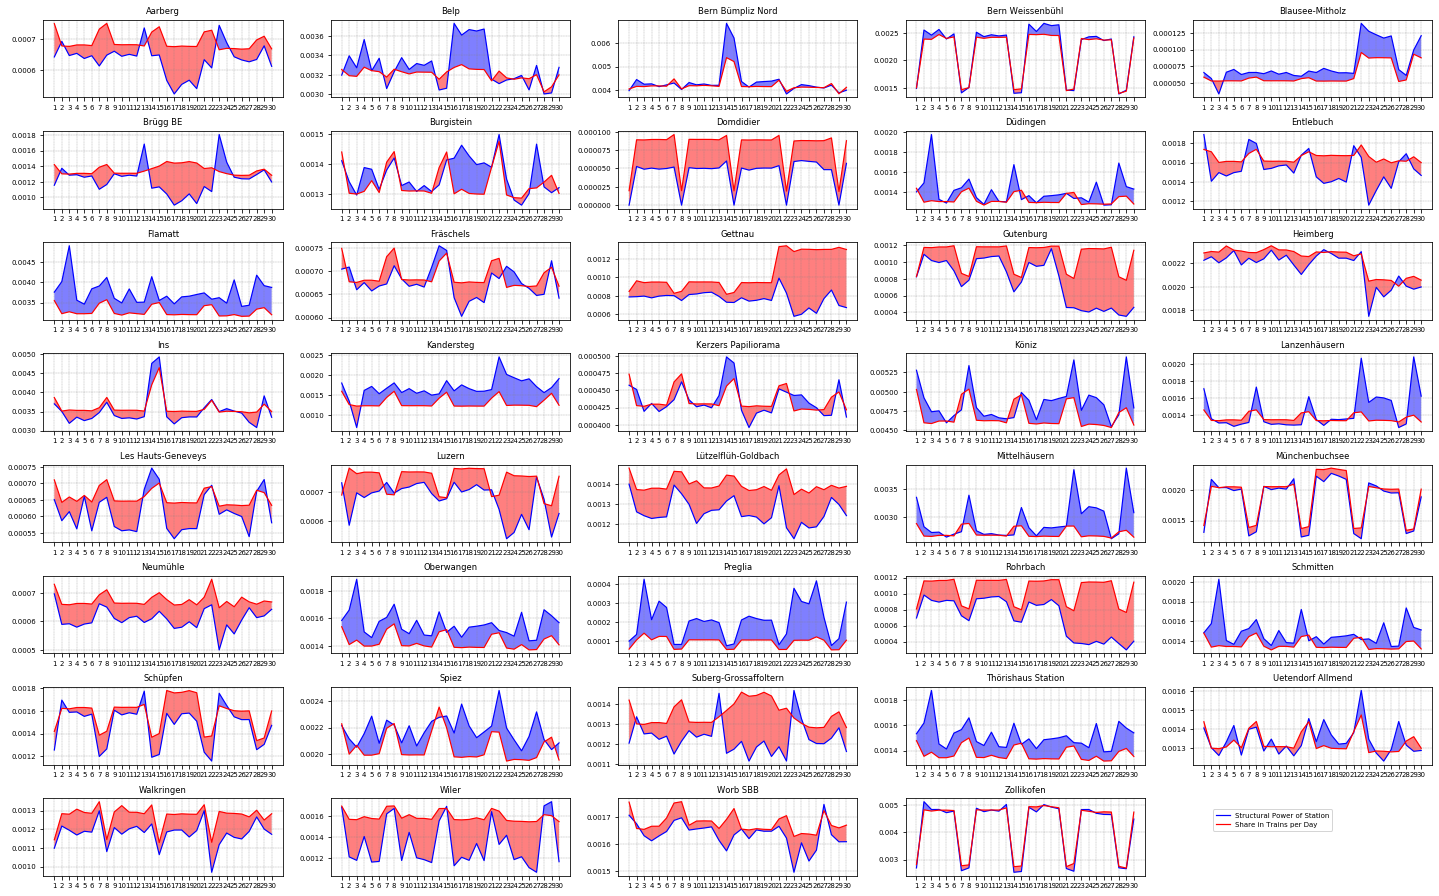

In [610]:
fig = plt.figure(figsize=(20, 20))
font = {'size': 7}
plt.rc('font', **font)

for j, i in enumerate(trange(0, len(indices), 5), 1):

    yPi = merge.loc[indices[i]][0::5].values
    yFreq = merge.loc[indices[i]][1::5].values

    plt.subplot(13, 5, j)
    plt.title(indices[i])

    plt.plot(
        range(len(steady_states)),
        yPi,
        '-b',
        linewidth=1.2,
        label='Structural Power of Station')
    plt.plot(
        range(len(steady_states)),
        yFreq,
        '-r',
        linewidth=1.2,
        label='Share in Trains per Day')
    
    y1 = yPi.astype(float)
    y2 = yFreq.astype(float)
    x = range(len(steady_states))

    plt.fill_between(
        x, y1, y2, where=y2 >= y1, facecolor='red', alpha=.5, interpolate=True)
    plt.fill_between(
        x, y1, y2, where=y2 <= y1, facecolor='blue', alpha=.5, interpolate=True)

    label = range(1, len(steady_states) + 1)
    plt.xticks(range(len(steady_states)), label)
    plt.tight_layout()
    plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.legend(bbox_to_anchor=(1.8, 0.9))
plt.show()
plt.close()

## Sensitivity analysis of Markov chains

In [639]:
# Sensitivity analysis on a single node
def change_node(M, i, percent=-99):
    eps = .001
    MC = M.T.copy()
        
    MC[i, :] = MC[i, :] * (1 + percent * .01)
    MC[:, i] = MC[:, i] * (1 + percent * .01)
    MC[i, i] = MC[i, i] / (1 + percent * .01)

    for i in range(MC.shape[0]):
        s = sum(MC[i])
        
        if s == 0:
            MC[i] = eps
            MC[i, i] = 1.
            s = sum(MC[i])
            MC[i] = np.divide(MC[i], s)

        else:
            MC[i] = np.divide(MC[i], s)

    return MC

In [825]:
percent = -99
#blackout_stations = ['Aarau', 'Bern', 'Chur', 'Landquart', 'Olten', 'Zürich HB']
blackout_stations = list(selected_states[0].index.values)

for d in trange(len(TMs)):
    TM = TMs[d].copy(deep=True)

    names_perturbed = []
    indices_perturbated = []

    Kemenys_perturbed = []
    Kemenys_diff = []

    Pi_perturbed = []
    Pi_diff = []

    e0 = time.time()

    K_normal, _ = Kemeny_constant(TM)
    pi_normal, _ = simulate_markov(TM, verbose='off')

    for station in blackout_stations:
        ind = np.where(TM.index == station)[0][0]
        Perturbed_TM = change_node(TM.values, ind, percent)

        K, _ = Kemeny_constant(Perturbed_TM)
        pi, _ = simulate_markov(Perturbed_TM, verbose='off')

        if np.any(pi < 0):
            flag = True
            print('something went wrong!')
        else:
            flag = False
            indices_perturbated.append(ind)
            names_perturbed.append(station)
            Kemenys_perturbed.append(K)
            Kemenys_diff.append(100 * (K - K_normal) / K_normal)
            Pi_perturbed.append(pi)
            Pi_diff.append(np.asarray(100 * (pi - pi_normal) / pi_normal))

    print("Sensitivity of TM {}, in {} second".format(
        datetime(year=2019, month=9, day=int(d + 1)),
        time.time() - e0))

    if not flag:
        DF = pd.DataFrame(
            index=names_perturbed, data=np.asarray(Pi_diff), columns=TM.index)
        path = 'data/istdaten/{}/perturbations/Pi_diff_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

        DF = pd.DataFrame(
            index=['pi_normal'],
            data=np.asarray(pi_normal)[np.newaxis, :],
            columns=TM.index)
        path = 'data/istdaten/{}/perturbations/pi_normal_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

        DF = pd.DataFrame(
            index=names_perturbed,
            data=np.asarray(Kemenys_diff),
            columns=['Kemeny_Change_PCT'])
        path = 'data/istdaten/{}/perturbations/Kemenys_diff_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

        DF = pd.DataFrame(
            index=names_perturbed,
            data=np.asarray(Pi_perturbed),
            columns=TM.index)
        path = 'data/istdaten/{}/perturbations/Pi_perturbed_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

Sensitivity of TM 2019-09-01 00:00:00, in 145.96404647827148 second
Sensitivity of TM 2019-09-02 00:00:00, in 145.01600193977356 second
Sensitivity of TM 2019-09-03 00:00:00, in 141.23499822616577 second
Sensitivity of TM 2019-09-04 00:00:00, in 149.4179973602295 second
Sensitivity of TM 2019-09-05 00:00:00, in 140.767719745636 second
Sensitivity of TM 2019-09-06 00:00:00, in 124.57099628448486 second
Sensitivity of TM 2019-09-07 00:00:00, in 139.80446648597717 second
Sensitivity of TM 2019-09-08 00:00:00, in 128.00699472427368 second
Sensitivity of TM 2019-09-09 00:00:00, in 124.75000166893005 second
Sensitivity of TM 2019-09-10 00:00:00, in 125.52799654006958 second
Sensitivity of TM 2019-09-11 00:00:00, in 125.17899823188782 second
Sensitivity of TM 2019-09-12 00:00:00, in 124.27699708938599 second
Sensitivity of TM 2019-09-13 00:00:00, in 128.70999789237976 second
Sensitivity of TM 2019-09-14 00:00:00, in 136.4759967327118 second
Sensitivity of TM 2019-09-15 00:00:00, in 136.685003

## Systemic fragility vs. systemic influence 

In [924]:
#SYSTEMIC ANALYSIS
@interact
def systemic(d=(0, len(selected_states) - 1), thresh=(60,90,1)):
    percent = -99


    pi_perturbed_path = 'data/istdaten/{}/perturbations/Pi_perturbed_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_perturbed = pd.read_pickle(pi_perturbed_path)
    pi_perturbed = pi_perturbed[list(selected_states[d].index.values)]

    pi_normal_path = 'data/istdaten/{}/perturbations/pi_normal_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_normal = pd.read_pickle(pi_normal_path)
    pi_normal = pi_normal[list(selected_states[d].index.values)]

    pi_diff_path = 'data/istdaten/{}/perturbations/Pi_diff_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_diff = pd.read_pickle(pi_diff_path)
    pi_diff = pi_diff[list(selected_states[d].index.values)]

    dim = pi_diff.shape[1]

    # Systemic Influence
    no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
    no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)

    ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affecting = np.zeros(dim)
    neg_affecting = np.zeros(dim)
    
    for i in range(dim):
        pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_pos_affecting[i]])
        neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_neg_affecting[i]])

    # We want to take out the effect each node on itself
    self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]

    sum_of_affecting = np.abs(neg_affecting) + pos_affecting - np.abs(self_change)
    pi_norm = pi_normal.values[0, :dim]

    systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / float(dim)

    # Systemic Fragility
    no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
    no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

    ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affected = np.zeros(dim)
    neg_affected = np.zeros(dim)

    for i in range(dim):
        pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]
        neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]

    systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / float(dim)

    sum_of_affected = np.abs(neg_affected) + pos_affected - np.abs(self_change)

    fig = plt.figure(figsize=(10, 7))
    plt.subplot(1, 1, 1)

    ax = plt.gca()

    x = systemic_fragility
    y = systemic_influence

    p = ax.scatter(
        x,
        y,
        c=pi_norm,
        s=pi_norm[:dim] * 15000,
        marker='o',
        edgecolor='gray',
        cmap=plt.cm.RdYlBu_r,
        alpha=1)

    plt.plot(x, y, 'ob', markersize=.3, alpha=.05)

    plt.xlabel('systemic fragility (absolute change > {}%)'.format(thresh))
    plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))

    cb = plt.colorbar(p, shrink=.6, pad=.02)
    cb.set_label('Steady state probability')


    xmin = x.min() - 0.05
    xmax = x.max() + 0.05

    ymin = y.min() - 0.01
    ymax = y.max() + 0.01

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    font = {'size': 14.}

    plt.rc('font', **font)
    plt.tight_layout()

    path = './markov/Images/Fragility_Influence.tiff'
    # fig.savefig(path, dpi=300)

    plt.show();
    cb.remove()
    plt.close();

interactive(children=(IntSlider(value=14, description='d', max=29), IntSlider(value=75, description='thresh', …

## Effects of shutting down stations on Kemeny constant

In [914]:
#KEMENY CHNAGE
@interact
def kemeny(d=(0, len(selected_states) - 1)):

    percent = -99

    Kemenys_diff_path = 'data/istdaten/{}/perturbations/Kemenys_diff_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    Kemenys_diff = pd.read_pickle(Kemenys_diff_path)

    pi_normal_path = 'data/istdaten/{}/perturbations/pi_normal_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_normal = pd.read_pickle(pi_normal_path)

    pi_normal = pi_normal[list(selected_states[d].index.values)]
    dim = pi_normal.shape[1]
    pi_norm = pi_normal.values[0, :dim]

    fig = plt.figure(figsize=(10, 7))
    plt.subplot(1, 1, 1)

    ax = plt.gca()
    ax.set_xscale('log')

    x = pi_norm
    y = Kemenys_diff.values[:dim]

    p = ax.scatter(
        x,
        y,
        c=pi_norm,
        s=pi_norm[:dim] * 15000,
        marker='o',
        edgecolor='gray',
        cmap=plt.cm.RdYlBu_r,
        alpha=1)


    plt.plot(x, y, 'ob', markersize=.3, alpha=.099)

    plt.xlabel('log scale-steady state probability (structural power)')
    plt.ylabel('Percent of Change in Kemeny Constant')

    cb = plt.colorbar(p, shrink=.6, pad=.02)
    cb.set_label('Steady state probability')

    xmin = x.min()+0.000005
    xmax = x.max()+0.005

    ymin = y.min()-30
    ymax = y.max()+30

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    font = {'size': 14.}

    plt.rc('font', **font)
    plt.tight_layout()

    path = './markov/Images/Kemeny_Eigen.tiff'
    #fig.savefig(path, dpi=300)

    plt.show();
    plt.close();

interactive(children=(IntSlider(value=14, description='d', max=29), Output()), _dom_classes=('widget-interact'…

## Network Visualization

In [ ]:
def station_graph(index):
    TM = TMs[index]
    timestamp = pd.DataFrame({'year': [2019], 'month': [9], 'day': [index + 1]})
    # Construct the graph
    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(list(TM.index)):
        for j, destination_state in enumerate(list(TM.columns)):
            rate = TM.iloc[i, j]
            if rate > 0:
                G.add_edge(
                    origin_state,
                    destination_state,
                    weight=rate,
                    Date=str(pd.to_datetime(timestamp)[0]))
    df = DFs[index].T.rename(
        columns={
            'Aarau': 'AA',
            'Bern': 'BE',
            'Chur': 'CH',
            'Landquart': 'LA',
            'Olten': 'OL',
            'Zürich HB': 'ZH'
        })
    attrs = pd.concat([df, steady_states[index]], axis=1).T.to_dict()
    #attrs = steady_states[index].T.to_dict()
    nx.set_node_attributes(G, attrs)
    return G

### Prepare for kepler.gl

In [ ]:
node_features = []
edge_features = []

In [ ]:
for index in trange(len(steady_states)-26):
    G = station_graph(index)
    graph = json_graph.node_link_data(G)
    for props in graph['nodes']:
        pos = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'id']].geopos.values[0]
        feature = Feature(Point(tuple(pos)), properties=props)
        node_features.append(feature)
    for props in graph['links']:
        source = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'source']].geopos.values[0]
        target = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'target']].geopos.values[0]
        feature = Feature(
            LineString([Point(tuple(source)),
                        Point(tuple(target))]), properties=props)
        edge_features.append(feature)

In [ ]:
# Gather all features
graph_features = node_features + edge_features
feature_collection = FeatureCollection(graph_features)

In [ ]:
# Write to file as geojson
with open('data/istdaten/September/map.geojson', 'w') as outfile:
     dump(feature_collection, outfile, indent=2, ensure_ascii=False)
outfile.close()

[See online app here](https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/s/p10n10r99h0lizi/keplergl_snm01s5.json)

### Interactive Plots

In [ ]:
def plot_station_graph(index, size, geo=True, labels=False, target='ZH'):
    G = station_graph(index)
    bond = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    # Get pagerank metrics on each node
    pi = np.array(list(nx.get_node_attributes(G, 'Pi').values()))
    pi_ = np.array(list(nx.get_node_attributes(G, target).values()))

    # Layout
    pos = nx.spring_layout(G, seed=1)
    if not geo:
        plt.figure(figsize=(50, 50))
        nx.draw(
            G,
            pos=pos,
            edge_color=bond,
            node_color=pi_,
            cmap=plt.cm.Accent,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, size),
            width=bond * 10,
            alpha=0.7)

    elif geo:
        # Overwrite random graph positions with the georeferenced locations
        geopos = pos.copy()
        for key, value in geopos.items():
            geopos[key] = np.array(locations.loc[locations['HALTESTELLEN_NAME']
                                                 == key].geopos.values[0])
        plt.figure(figsize=(50, 35))
        nx.draw(
            G,
            pos=geopos,
            edge_color=bond,
            node_color=pi_,
            cmap=plt.cm.viridis,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, size),
            width=bond * 10,
            alpha=0.7)

    plt.show()

In [ ]:
interact(
    plot_station_graph,
    index=(0, 29),
    size=(4.5, 6.0),
    geo={True, False},
    labels={True, False},
    target={'AA','BE','CH','LA','OL','ZH'});

## Export the Graph

In [ ]:
# Write to file for further visualization

index=0
write_dot(station_graph(index), 'data/mc.dot')

[See visualization here](https://nbviewer.jupyter.org/github/GAnagno/Social-Web/blob/master/data/markov/01092019.png)